In [17]:
# this cell imports the libraries or packages that you can use during this assignment
# you are not allowed to import additional libraries or packages

from helpers import *
import os
import itertools
import numpy as np
import pandas as pd

# Machine Learning and Decomposition
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import skfuzzy as fuzz

# Statistical tools
from scipy.stats import multivariate_normal
from scipy import linalg

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap, LogNorm
import seaborn as sns

> **Important**
>
> Do not import any other packages or libraries than the ones already provided to you. You can only use the imported packages _after_ they have been imported.
>
> Write your code between the `BEGIN_TODO` and `END_TODO` markers. Do not change these markers.
>
> Restart your notebook and run all cells before submission.

---
---
---

# Assignment 1b

## Introduction
In this assignment you will learn about different data analysis methods for creating a biking lane detector with the data you have collected in Assignment 1a.This assignment is split into 4 parts. Part 1 will introduce K-means clustering aglorithm and guide you through its implementations and limitations. Part 2 will introduce fuzzy c-means algorithm. Part 3 will explain Gaussian mixture model (GMM), which you will train using the expectation-maximization algorithm. Eventually you are expected to train GMM on your biking data, and use it to assess the biking lane quality of a route in Tilburg.

### Learning goals
After this assignment you can

- implement the K-means algorithm;
- explain issues and shortcomings of the K-means algorithm;
- implement the fuzzy c-means algorithm;
- implement the Gaussian mixture model;
- explain how the Gaussian mixture model differs from the previous algorithms;
- test your model against real world testing set to detect the biking lane quality.

## Part 1: K-means algorithm
In this part we will discuss unsupervised machine learning problems and describe how the K-means algorithm can be used to solve these.

Unsupervised machine learning problems are problems in which we try to determine some particular structure within a data set. Alternatively, supervised machine learning problems require us to model some kind of input-output mapping. Unsupervised machine learning problems do not have a specified output which we would like to model. Instead we are insterested in making sense of the data and in grouping this data, without knowing beforehand which and how many groups exist.

The K-means algorithm can group $N$ data samples of dimension $D$ into $K$ groups or clusters. These clusters can each be characterized by their mean vector: the expected or average value of the points which are assigned to the cluster. The mean vector denoting the center of the $k^{th}$ cluster can be represented as the column vector ${\bf{\mu}}^{(k)} = [\mu_1^{(k)},\ \mu_2^{(k)},\ \ldots, \mu_D^{(k)}]^\top$ and the $n^{th}$ data sample can be represented by the column vector ${\bf{x}}^{(n)} = [x_1^{(n)},\ x_2^{(n)},\ \ldots, x_D^{(n)}]^\top$, where the superscript denotes the sample index.

The K-means algorithm tries to minimize the (within-cluster) Euclidean squared distance
$$J({\bf{X}}, {\bf{\mu}}) = \frac{1}{N}\sum_{n=1}^N \sum_{k=1}^K \rho_k^{(n)} \| {\bf{x}}^{(n)} - {\bf{\mu}}^{(k)}\|^2$$
Here $\rho_k^{(n)}$ is a so-called indicator function that is defined as 
$$ \rho_k^{(n)} = \begin{cases} 1 & \text{if sample }{\bf{x}}^{(n)}\text{ is assigned to cluster }k \\ 0 & \text{otherwise}\end{cases}$$
This indicator function equals $1$ when the corresponding data point is assigned to the corresponding cluster and $0$ otherwise. The cost function therefore represents the average squared distance with respect to the cluster that a point is assigned to.

The algorithm is specified as follows:

1. Initialize means ${\bf{\mu}}$.
2. Assign data points to closest cluster mean (i.e. update $\rho_k^{(n)}$).
3. Calculate new cluster means as the average values of the points that are assigned to it (i.e. update ${\bf{\mu}}$).
4. Calculate cost function $J({\bf{X}}, {\bf{\mu}})$.
5. If not converged, go back to 2 and repeat.

Here we will describe the algorithm in words. First the centers of the clusters are initialized. This can be done arbitrarily, but often the centers are set to random (but distinct) samples of the data set.
Once the means are set, we assign each data sample to the cluster that is closest to it. In order to do so, we calculate the Euclidean squared distance between a point and all the clusters and find the cluster that is closest to it. We repeat this for all points and we therefore completely specify $\rho_k^{(n)}$. Once all points have been assigned to a cluster, we look up all points corresponding to a certain cluster and we average these to calculate the new cluster center. We update all cluster means. Then we evaluate the current fit of the clusters on the data by evaluating the cost function. If we still see a significant improvement in the cost function, we repeat updating the assignments and cluster centers and if the cost function seems to have converged, we stop iterating.

In this part of the assignment you will implement the K-means algorithm from scratch, starting with the initialization of the cluster means.


---
---
### Exercise 1.1: Initializing cluster centers
Consider the function `X = ex3_generate_data()` which generates a matrix ${\bf{X}}$ of shape (N x D), representing the vertical concatenation of $N$ transposed data vectors of dimension $D$. Create a function `means = initialize_means(X, K)` that accepts the data set ${\bf{X}}$  and number of clusters $K$ as input and returns a matrix of shape (K x D), representing the vertical concatenation of $K$ transposed mean vectors of dimension $D$. These means should be initialized such that they coincide with *random* samples from the data set, which are always *distinct*. In other words, the means should equal a random subset of the availabe data set, where no means are equal. Also keep in mind that the number of clusters is variable in this function.

In [18]:
#// BEGIN_TODO Complete the function initialize_means(X, K)

def initialize_means(X, K):

    random_mean_index = np.random.choice(X.shape[0], K, replace=False)
    cluster_centers = X[random_mean_index]
    
    return cluster_centers
  
#// END_TODO

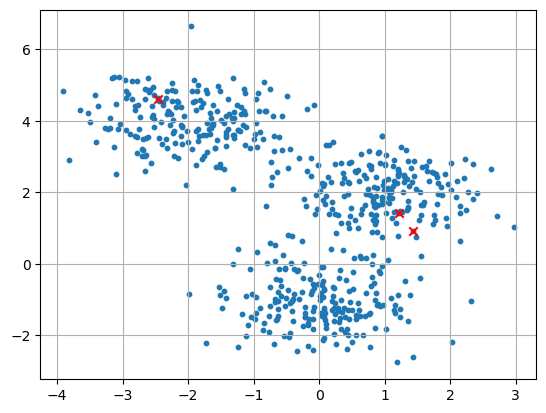

In [19]:
# generate data
X = ex3_generate_data()

# initialize means
means = initialize_means(X, 3)

# plot data
plt.figure()
plt.scatter(X[:,0], X[:,1], 10)
plt.scatter(means[:,0], means[:,1], c="red", marker="x")
plt.grid()

### End of exercise 1.1
---
---

Now that the clusters have been initialized, it is time to assign points to the closest clusters.

---
---
### Exercise 1.2: Assign points to clusters
Again consider the function `X = ex4_generate_data()` which generates a matrix ${\bf{X}}$ of shape (N x D), representing the vertical concatenation of $N$ transposed data vectors of dimension $D$. Create a function `rho = assign_data_to_clusters(X, means)` that accepts the data set ${\bf{X}}$ and matrix of means ${\bf{\mu}}$ as input and returns a matrix of shape (N x K), which contains all indicator functions $\rho_k^{(n)}$. This matrix should be a matrix of only ones and zeros and each row should sum to 1. Note that this is essentially the partition matrix.

In [20]:
#// BEGIN_TODO Complete the function assign_data_to_clusters(X, means)

def assign_data_to_clusters(X, means):
    assign_clusters = []
    
    for data_point in X:
        distances = np.sqrt(np.sum((data_point - means)**2, axis=1))
        cluster_number = np.argmin(distances)
        assign_clusters.append(cluster_number)

    initial_data_to_cluster = []

    for i in assign_clusters:
        zero_array = np.zeros(means.shape[0])
        zero_array[i] = 1
        initial_data_to_cluster.append(zero_array)

    initial_data_to_cluster = np.array(initial_data_to_cluster)
    
    return initial_data_to_cluster

means = initialize_means(X, 3)
rho = assign_data_to_clusters(X, means)

#// END_TODO 

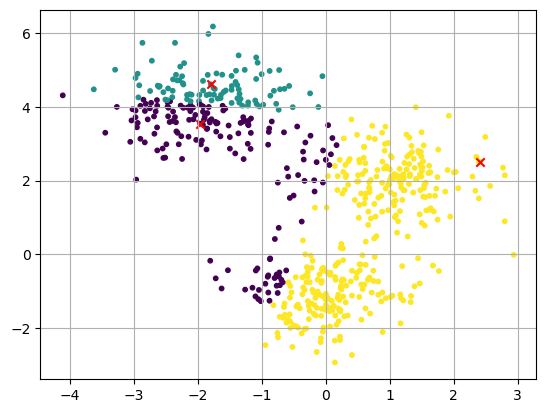

In [21]:
# generate data
X = ex3_generate_data()

# initialize means
means = initialize_means(X, 3)

# assign point to clusters
rho = assign_data_to_clusters(X, means)
assert np.allclose(np.sum(rho, axis=1), 1), "Sum of probabilities for each point does not add up to 1!"

# plot data
plt.figure()
plt.scatter(X[:,0], X[:,1], 10, c=np.argmax(rho, axis=1))
plt.scatter(means[:,0], means[:,1], c="red", marker="x")
plt.grid()

### End of exercise 1.2
---
---

The means have been initialized, the points have been assigned to clusters. Now the cluster centers can be updated.

---
---
### Exercise 1.3: Update cluster centers

Again consider the function `X = ex3_generate_data()` which generates a matrix ${\bf{X}}$ of shape (N x D), representing the vertical concatenation of $N$ data vectors of dimension $D$. Create a function `means = update_cluster_centers(X, rho)` that accepts the data set ${\bf{X}}$ and matrix of indicators $\rho$ as input and returns a matrix of shape (K x D), which contains the new cluster centers.

In [22]:
#// BEGIN_TODO  Complete the function update_cluster_centers(X, rho)

def update_cluster_centers(X, rho):
    K = rho.shape[1]
    update_clusters = [[] for _ in range(K)]
    for i in range(len(rho)):
        a = np.argmax(rho[i])
        update_clusters[a].append(X[i])

    cluster_centers = []
    for i in range(K):
        cluster_centers.append(np.mean(update_clusters[i], axis=0))

    cluster_centers = np.array(cluster_centers)
        
    return cluster_centers

#// END_TODO 

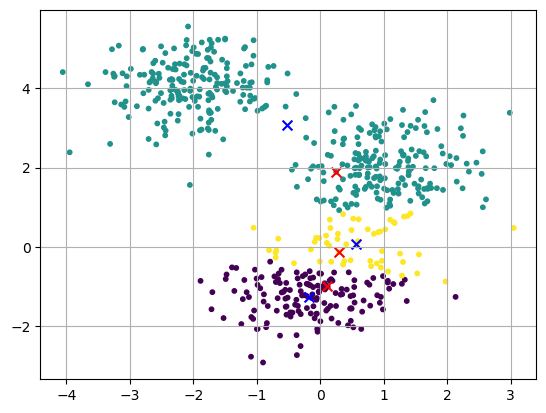

In [23]:
# generate data
X = ex3_generate_data()

# initialize means
means = initialize_means(X, 3)

# assign point to clusters
rho = assign_data_to_clusters(X, means)

# update means
means_new = update_cluster_centers(X, rho)

# plot data
plt.figure()
plt.scatter(X[:,0], X[:,1], 10, c=np.argmax(rho, axis=1))
plt.scatter(means[:,0], means[:,1], 50, c="red", marker="x")
plt.scatter(means_new[:,0], means_new[:,1], 50, c="blue", marker="x")
plt.grid()

### End of exercise 1.3
---
---

Almost there! Now it is just a matter of combining the previous functions for finalizing the K-means algorithm.

---
---
### Exercise 1.4: Implement K-means algorithm

First create a function `J = Kmeans_loss(X, means, rho)` that calculates the within-cluster Euclidean squared distance as defined above. Secondly create the final `means, rho, J = Kmeans(X, K)` function that combines all previous functions to create the K-means algorithm as specified in the the introduction of this part of the assignment. This function returns the final cluster centers, the indicator function and a history of the losses. Save the loss *after* each iteration and stop iterating when the difference in loss does no longer exceed 1e-10. The initial loss based on the randomly initialized means should not be returned.

In [24]:
#// BEGIN_TODO Complete the Kmeans_loss(X, means, rho) function

def Kmeans_loss(X, means, rho):
    N = X.shape[0]
    K = means.shape[0]

    total_loss = 0

    for n in range(N):
        for k in range(K):
            if rho[n, k] == 1:
                total_loss += np.sum((X[n] - means[k])**2)

    J = total_loss / N
    return J
    
#// END_TODO 

In [25]:
#// BEGIN_TODO  Complete the Kmeans(X, K) function

def Kmeans(X, K):
    max_iterations = 1000
    means = initialize_means(X, K)
    history_of_losses = []

    for iteration in range(max_iterations):
        rho = assign_data_to_clusters(X, means)
        means_new = update_cluster_centers(X, rho)
        current_loss = Kmeans_loss(X, means, rho)

        if iteration > 0:
            most_recent_loss = history_of_losses[-1]
            if abs(most_recent_loss - current_loss) < 1e-10:
                break
            
        history_of_losses.append(current_loss)
        means = means_new

    return means, rho, history_of_losses

#// END_TODO 

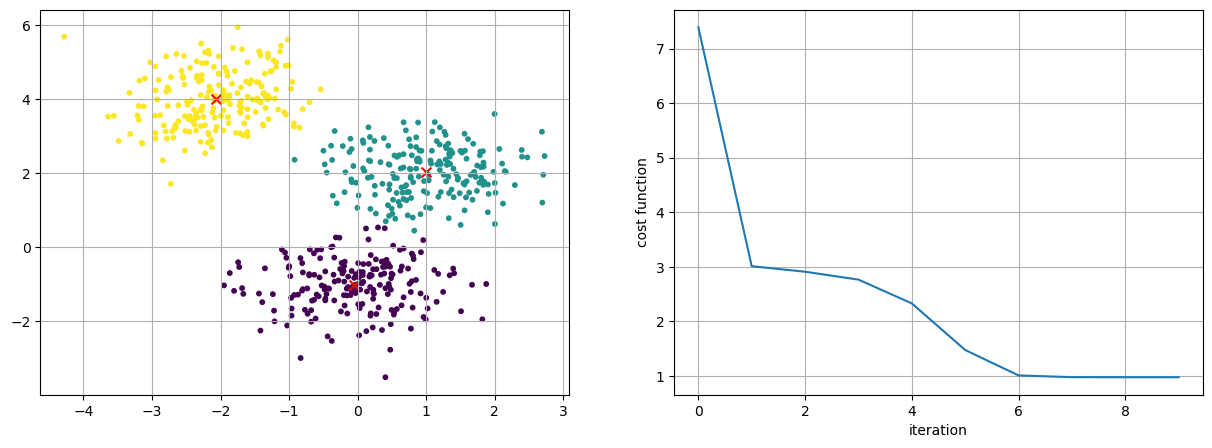

In [26]:
# generate data
X = ex3_generate_data()

# initialize means
means, rho, J = Kmeans(X, 3)

# plot data
_,ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].scatter(X[:,0], X[:,1], 10, c=np.argmax(rho, axis=1))
ax[0].scatter(means[:,0], means[:,1], 50, c="red", marker="x")
ax[1].plot(J)
ax[0].grid(), ax[1].grid(), ax[1].set_ylabel("cost function"), ax[1].set_xlabel("iteration");

### End of exercise 1.4
---
---

---
---
### Exercise 1.5: Number of clusters
In the previous assignment the data had been generated from 3 clusters. In practice the number of clusters is often unknown. In this exercise we will see what happens when we add extra clusters. Run your K-means algorithm on the previous data set for 2 up to and including 10 clusters and save the final value of the loss (i.e. the loss value when the algorithm has converged).

Plot the final loss against the number of used clusters.

In [27]:
# generate data
X = ex3_generate_data()

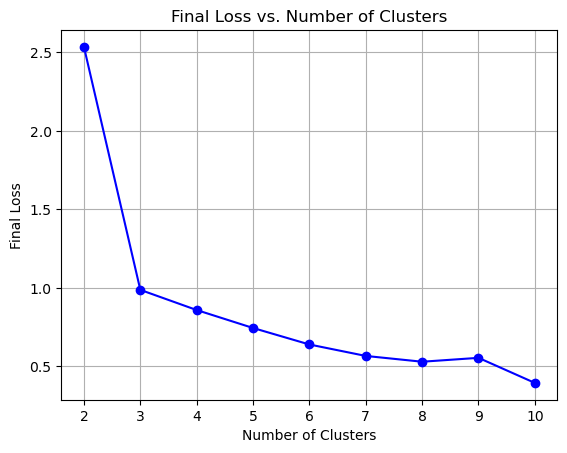

In [28]:
#// BEGIN_TODO Plot the Kmeans loss against the number of clusters

final_losses = []
cluster_numbers = [i for i in range(2,11)]

for i in range(2, 11):
    _, _, J = Kmeans(X, i)
    final_losses.append(J[-1])

# Plot final loss against number of clusters
plt.figure()
plt.plot(cluster_numbers, final_losses, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Clusters")
plt.ylabel("Final Loss")
plt.title("Final Loss vs. Number of Clusters")
plt.grid(True)
plt.show()

#// END_TODO 

Does the loss give a good impression of how many clusters can be found in the data set. Please motivate your answer.


In [29]:
#// BEGIN_TODO Finding an appropriate number of clusters

answer = """
The loss gives a good impression of how many clusters can be found in the dataset as we can observe a pattern known as the "elbow" method to help identify the optimal number of K clusters. The idea of this is to find a 
point where the loss significantly decreases before the graph starts looking like a straight line. Based on the figure, the elbow can be found at k=3 and thus the data likely has 3 natural clusters, as adding more 
clusters beyond this point yields diminishing returns in terms of reducing the loss (the drop in loss from 2 to 3 is large, while the improvement from 3 to 4 and beyond is smaller and more gradual). 
"""

print(answer)
#// END_TODO 


The loss gives a good impression of how many clusters can be found in the dataset as we can observe a pattern known as the "elbow" method to help identify the optimal number of K clusters. The idea of this is to find a 
point where the loss significantly decreases before the graph starts looking like a straight line. Based on the figure, the elbow can be found at k=3 and thus the data likely has 3 natural clusters, as adding more 
clusters beyond this point yields diminishing returns in terms of reducing the loss (the drop in loss from 2 to 3 is large, while the improvement from 3 to 4 and beyond is smaller and more gradual). 



### End of exercise 1.5
---
---

---
---
### Exercise 1.6: Shortcomings of the K-means algorithm
Apply the K-means algorithm for the new data set generated by `X = ex36_generate_data()`. Visualise the data and come up with an appropriate number of clusters. Plot the data points in a scatter plot, plot the means as red crosses in the same plot and color the data point according to their assigned cluster.

In [30]:
# generate data
X = ex36_generate_data()

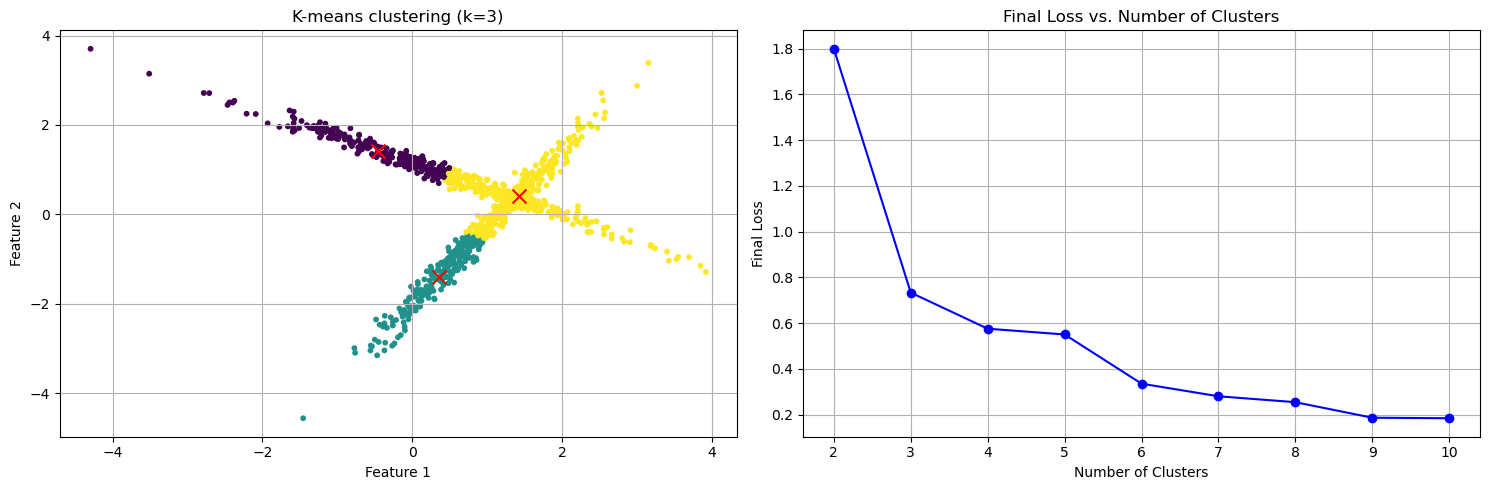

In [31]:
#// BEGIN_TODO  Plot clusters for the new data set

final_losses = []
cluster_numbers = [i for i in range(2,11)]

for i in range(2, 11):
    _, _, J = Kmeans(X, i)
    final_losses.append(J[-1])

# After visualizing the data, we decided the appropriate k is 3 due to the elbow method, where the final loss has diminshing returns after k=3
appropriate_k = 3
means, rho, J = Kmeans(X, appropriate_k)

# Create plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Scatter plot of the data colored by clusters
scatter = ax[0].scatter(X[:, 0], X[:, 1], c=np.argmax(rho, axis=1), s=10)
ax[0].scatter(means[:, 0], means[:, 1], c="red", marker="x", s=100)  
ax[0].set_title(f"K-means clustering (k={appropriate_k})")
ax[0].set_xlabel("Feature 1")
ax[0].set_ylabel("Feature 2")
ax[0].grid(True)

# Plot final loss against number of clusters
ax[1].plot(cluster_numbers, final_losses, marker="o", linestyle="-", color="b")
ax[1].set_title("Final Loss vs. Number of Clusters")
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel("Final Loss")
ax[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()

#// END_TODO 

### End of exercise 1.6
---
---

---
---
### Exercise 1.7: Clustering biking data
Apply the K-means algorithm on the biking data you have collected from assignment 1a, namely the three matrices, combined_features, smooth_features and bumpy_features. Employ PCA with 2 components before you apply K-means. Visualize the data with the cluster centers, and determine the optimum number of clusters for each matrix. For this task, you can use scikit learn packages.



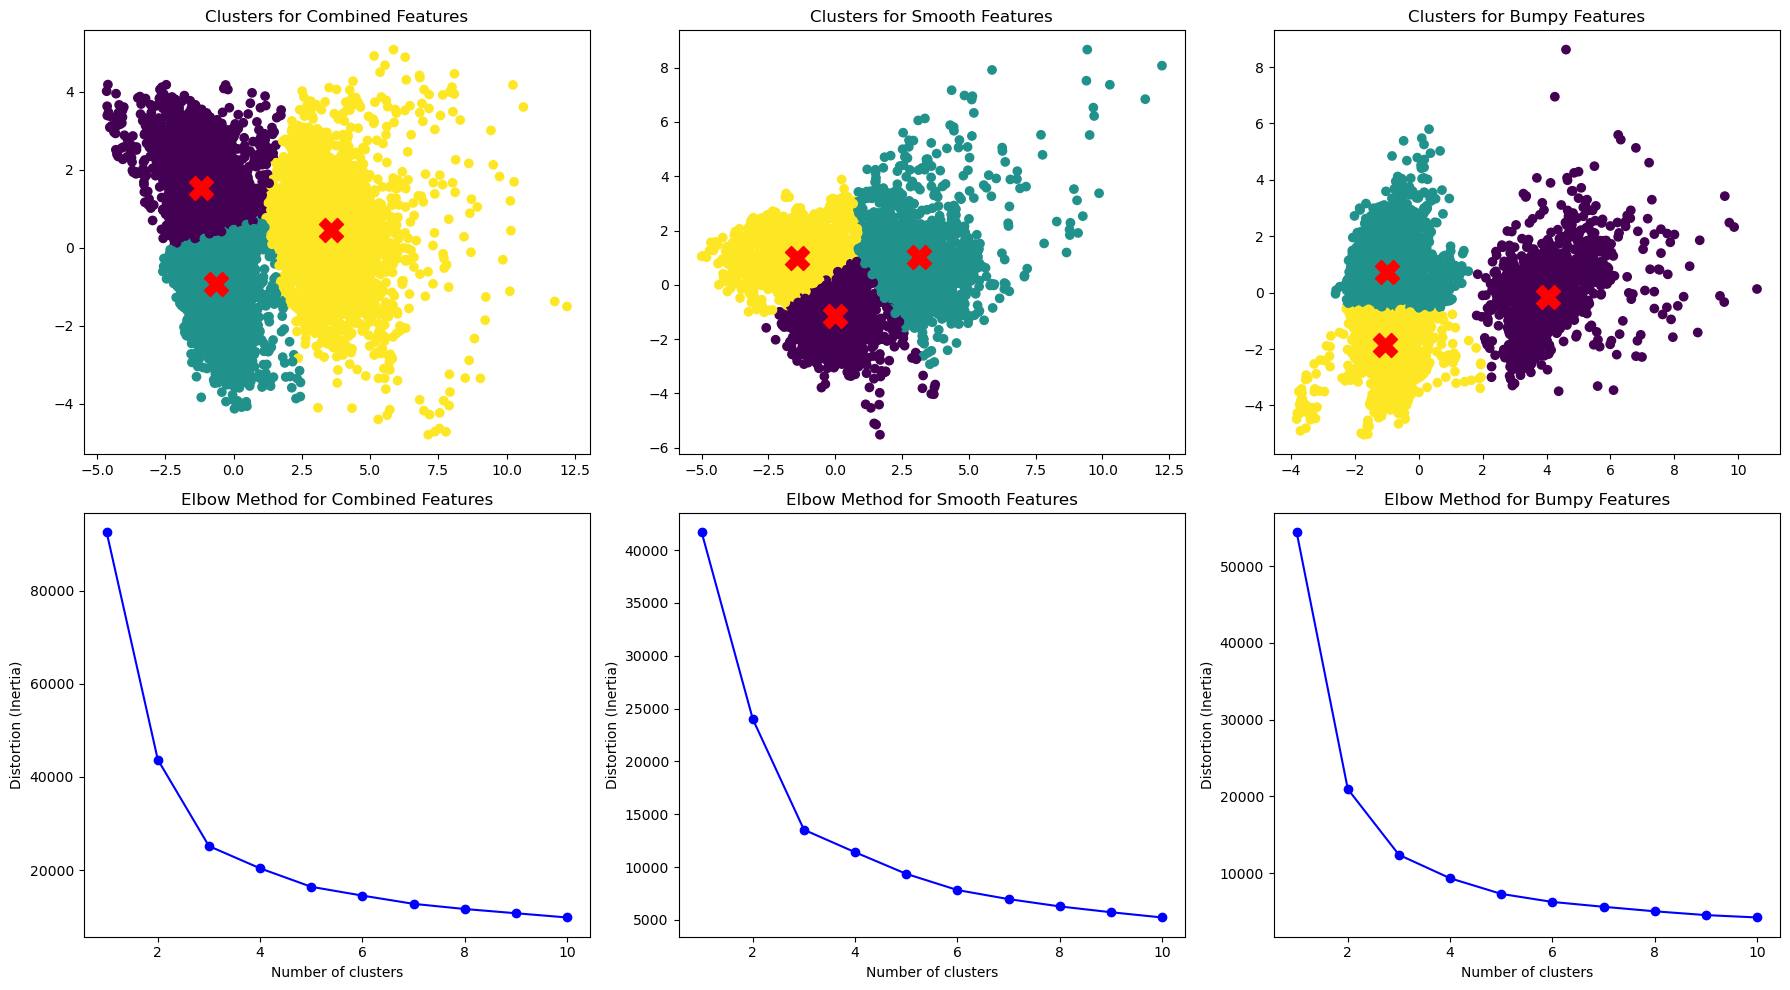

In [63]:
#// BEGIN_TODO  apply k-means and visualize cluster centers and determine optimum number of clusters for each matrix

# Manual transfer of the three matrices via CSV files
combined_features = pd.read_csv('manual_feature_transfer/combined_features.csv').values
bumpy_features = pd.read_csv('manual_feature_transfer/bumpy_features.csv').values
smooth_features = pd.read_csv('manual_feature_transfer/smooth_features.csv').values

# Function to perform PCA with 2 components
def apply_pca(data):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    return reduced_data

# Function to apply K-means
def apply_kmeans(data, K):
    kmeans = KMeans(n_clusters=K, n_init=10)
    kmeans.fit(data)
    return kmeans

# Function to find optimal number of clusters and return distortions
def find_optimal_clusters(data):
    distortions = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    return distortions

# Plotting function for both clusters and elbow plots in one go
def plot_clusters_and_elbow(data, kmeans, distortions, ax_cluster, ax_elbow, title):
    # Plot the clustered data
    ax_cluster.scatter(data[:, 0], data[:, 1], c=kmeans.labels_, cmap='viridis')
    ax_cluster.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')
    ax_cluster.set_title(f'Clusters for {title}')
    
    # Plot the elbow method
    K_range = range(1, 11)
    ax_elbow.plot(K_range, distortions, 'bo-')
    ax_elbow.set_xlabel('Number of clusters')
    ax_elbow.set_ylabel('Distortion (Inertia)')
    ax_elbow.set_title(f'Elbow Method for {title}')

# Apply PCA on each matrix
combined_features_pca = apply_pca(combined_features)
smooth_features_pca = apply_pca(smooth_features)
bumpy_features_pca = apply_pca(bumpy_features)

# Define the number of clusters (assumed 3 for demonstration, based on elbow method)
optimal_k_combined = 3
optimal_k_smooth = 3
optimal_k_bumpy = 3

# Apply K-means for each dataset
kmeans_combined = apply_kmeans(combined_features_pca, optimal_k_combined)
kmeans_smooth = apply_kmeans(smooth_features_pca, optimal_k_smooth)
kmeans_bumpy = apply_kmeans(bumpy_features_pca, optimal_k_bumpy)

# Compute distortions for elbow method
distortions_combined = find_optimal_clusters(combined_features_pca)
distortions_smooth = find_optimal_clusters(smooth_features_pca)
distortions_bumpy = find_optimal_clusters(bumpy_features_pca)

# Create a 2x3 plot grid (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot the clusters and elbow for each matrix
plot_clusters_and_elbow(combined_features_pca, kmeans_combined, distortions_combined, axes[0, 0], axes[1, 0], 'Combined Features')
plot_clusters_and_elbow(smooth_features_pca, kmeans_smooth, distortions_smooth, axes[0, 1], axes[1, 1], 'Smooth Features')
plot_clusters_and_elbow(bumpy_features_pca, kmeans_bumpy, distortions_bumpy, axes[0, 2], axes[1, 2], 'Bumpy Features')

# Adjust the layout for better visualization
plt.tight_layout()
plt.show()

#// END_TODO 

In [33]:
#// BEGIN_TODO determine optimum number of clusters quantitatively`

def calculate_optimal_clusters(inertia_values):
    # Calculate differences in inertia
    inertia_diff = np.diff(inertia_values)

    # Calculate ratio of differences
    inertia_diff_ratio = inertia_diff[1:] / inertia_diff[:-1]

    # Find where the ratio is below 0.1
    indices = np.argwhere(inertia_diff_ratio < 0.3)
    
    optimal_clusters = indices[0][0] + 2  # Adjust for zero-indexing
    return optimal_clusters

optimal_combined = calculate_optimal_clusters(distortions_combined)
optimal_smooth = calculate_optimal_clusters(distortions_smooth)
optimal_bumpy = calculate_optimal_clusters(distortions_bumpy)

print(f"Optimal number of clusters for Combined Features: {optimal_combined}")
print(f"Optimal number of clusters for Smooth Features: {optimal_smooth}")
print(f"Optimal number of clusters for Bumpy Features: {optimal_bumpy}")

#// END_TODO`


Optimal number of clusters for Combined Features: 3
Optimal number of clusters for Smooth Features: 3
Optimal number of clusters for Bumpy Features: 2


`#// BEGIN_TODO motivate your answer behind the number of clusters`

First of all, inertia measures the sum of squared distances between data points and their respective cluster centers. It provides insight into how well the data is being clustered. We used ratios as our quantitative measure. By calculating the ratio of the differences in inertia, we assess how much additional clustering (increasing k) is impacting the inertia. A smaller ratio indicates that the reduction in inertia is less significant relative to the increase in clusters. A threshold of 0.3 for this ratio was defined to indicate a point where the additional clusters do not significantly contribute to better clustering performance. When deciding the threshold, we knew a threshold too low would yield very few clusters, while a threshold too high might overlook the beneficial addition of clusters. With this threshold, we obtained the following optimal number of clusters:

- Combined features: 3
- Smooth features: 3
- Bumpy features: 2

The elbow method plot (a qualitative measure) supports this quantitative finding. For the combined and smooth features plot, the inertia sharply declines up to 3 clusters, after which the decrease becomes more gradual. This indicates that adding more clusters beyond 3 yields diminishing returns in terms of reducing distortion, as the additional clusters capture less meaningful variance in the data. As for the bumpy feature plot, this case is up to 2 clusters. Anything more is not very significant.

`#// END_TODO`


### End of exercise 1.7
---
---

## Part 2: Fuzzy C-Means Algorithm

In this part, we will explore another unsupervised machine learning algorithm known as Fuzzy C-Means (FCM). Unlike K-means, which assigns each data point to a single cluster, FCM allows each data point to belong to multiple clusters with varying degrees of membership.

FCM is particularly useful when cluster boundaries are not well-defined. It provides a nuanced understanding of the data by allowing overlapping clusters, which is more appropriate when the data naturally overlaps between clusters.

### Overview
The Fuzzy C-Means algorithm groups $N$ data samples of dimension $D$ into $C$ clusters, where each cluster is characterized by its cluster center, denoted by the column vector ${\bf{v}}^{(k)} = [v_1^{(k)},\ v_2^{(k)},\ \ldots, v_D^{(k)}]^\top$, similar to the mean vector in K-means. However, instead of assigning each data point to a single cluster, FCM assigns a membership value, denoted by $\mu_k^{(n)}$, to each data point for each cluster. This membership value indicates the degree with which the data point belongs to the cluster.

The membership values for the $n^{\text{th}}$ data sample across all clusters are represented by the vector ${\bf{\mu}}^{(n)} = [\mu_1^{(n)}, \mu_2^{(n)}, \ldots, \mu_C^{(n)}]^\top$, where $\mu_k^{(n)}$ is the membership value of the $n^{\text{th}}$ data sample in the $k^{\text{th}}$ cluster. These membership values satisfy two conditions:
1. $0 \leq \mu_k^{(n)} \leq 1$ for all $k$ and $n$.
2. $\sum_{k=1}^C \mu_k^{(n)} = 1$ for each $n$.

The algorithm aims to minimize the following objective function:

$$
J({\bf{X}}, {\bf{U}}, {\bf{V}}) = \frac{1}{N}\sum_{n=1}^N \sum_{k=1}^C (\mu_k^{(n)})^m \| {\bf{x}}^{(n)} - {\bf{v}}^{(k)}\|^2
$$

Here:
- ${\bf{U}}$ represents the matrix of membership values.
- ${\bf{v}}^{(k)}$ represents the cluster center of the $k^{\text{th}}$ cluster.
- $m > 1$ is a weighting exponent that determines the fuzziness of the membership values.

### The Fuzzy C-Means Algorithm

1. **Initialize the Membership Matrix ${\bf{U}}$:**
   - Randomly initialize the membership values ${\bf{U}}$ such that they satisfy the constraints mentioned above.

2. **Calculate Cluster Centers ${\bf{v}}$:**
   - Compute the cluster center of each cluster as a weighted average of the data points, with weights given by the membership values:
   $$
   {\bf{v}}^{(k)} = \frac{\sum_{n=1}^N (\mu_k^{(n)})^m \cdot {\bf{x}}^{(n)}}{\sum_{n=1}^N (\mu_k^{(n)})^m}
   $$

3. **Update Membership Values ${\bf{U}}$:**
   - Update the membership values based on the distance between each data point and the cluster centers:
   $$
   \mu_k^{(n)} = \frac{1}{\sum_{j=1}^C \left(\frac{\|{\bf{x}}^{(n)} - {\bf{v}}^{(k)}\|}{\|{\bf{x}}^{(n)} - {\bf{v}}^{(j)}\|}\right)^{\frac{2}{m-1}}}
   $$

4. **Calculate the Cost Function $J({\bf{X}}, {\bf{U}}, {\bf{V}})$:**
   - Evaluate the current fit of the clusters using the objective function defined earlier.

5. **Check for Convergence:**
   - If the change in the cost function or the change in cluster centers is below a predefined threshold, stop the iteration. Otherwise, go back to step 2.



### Exercise 2.1: Initialization 
Initialize the membership partition matrix `U`. Choose also an appropriate value for $m$.


In [34]:
X = ex11_generate_data()

In [35]:
#// BEGIN_TODO  Initialization

k = 2
m = 2

def initialize_U(X, k):
    U = np.random.rand(X.shape[0], k)
    U = U / np.sum(U, axis=1, keepdims=True)
    return U

U = initialize_U(X, k)
#// END_TODO 

In [36]:
print("Initial Membership Matrix (U):")
print(U)

Initial Membership Matrix (U):
[[0.65435137 0.34564863]
 [0.7324071  0.2675929 ]
 [0.25505769 0.74494231]
 ...
 [0.29283535 0.70716465]
 [0.92469033 0.07530967]
 [0.25062663 0.74937337]]


### End of exercise 2.1
---
---

### Exercise 2.2: Update cluster centers 
Update the cluster centers `V` based on the current membership matrix.


In [37]:
#// BEGIN_TODO  Update cluster centers

def update_centroids(X, k, U, m):
    V = np.zeros((k, X.shape[1]))
    for i in range(k):
        V[i, :] = np.sum((U[:,i]**m)[:, np.newaxis]*X, axis=0)/np.sum(U[:,i]**m)
    return V

V = update_centroids(X, k, U, m)

#// END_TODO 

In [38]:
print("Updated fuzzy Cluster Centers (V):")
print(V)

Updated fuzzy Cluster Centers (V):
[[5.14389384 8.61662317]
 [5.12044044 8.5101442 ]]


### End of exercise 2.2
---
---

### Exercise 2.3: Update membership values
Update the membership matrix `U` based on the current cluster centers.


In [39]:
#// BEGIN_TODO# update partition matrix

def update_membership(X, V, k, m):
    dist = np.linalg.norm(X[:, np.newaxis, :] - V[np.newaxis, :, :], axis=2)
    U = 1/ np.sum((dist[:, :, np.newaxis] / dist[:, np.newaxis, :])**(2/(m-1)), axis=2)
    return U

U = update_membership(X, V, k, m)
#// END_TODO 

In [40]:
print("Updated Membership Matrix (U):")
print(U)

Updated Membership Matrix (U):
[[0.49717537 0.50282463]
 [0.48583144 0.51416856]
 [0.48714063 0.51285937]
 ...
 [0.50074421 0.49925579]
 [0.49470136 0.50529864]
 [0.5016022  0.4983978 ]]


### End of exercise 2.3
---
---

### Exercise 2.4: Repeat until convergence
employ iterative optimization and repeat until convergence, stop iterations when the convergence threshold ${\epsilon}\  < 10^{-5} $


In [41]:
#// BEGIN_TODO Repeat until convergence

max_iterations = 1000
for iteration in range(max_iterations):
    V = update_centroids(X, k, U, m)
    U_new = update_membership(X, V, k, m)
    
    if np.linalg.norm(U_new - U) < 0.00001:
        break

    U = U_new


#// END_TODO 

In [42]:
print("Final Cluster Centers (V):")
print(V)
print("Final Membership Matrix (U):")
print(U)

Final Cluster Centers (V):
[[3.07337179 9.81331782]
 [7.32582344 7.21419766]]
Final Membership Matrix (U):
[[0.01122415 0.98877585]
 [0.16419057 0.83580943]
 [0.02736729 0.97263271]
 ...
 [0.85842592 0.14157408]
 [0.09680147 0.90319853]
 [0.9838696  0.0161304 ]]


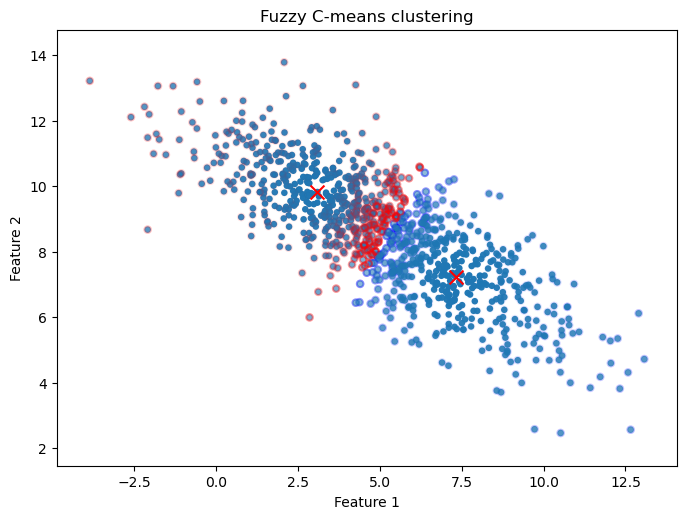

In [43]:
def plot_fuzzy_membership(X, U):
    """
    Plot the data points with fill color based on membership to both clusters.
    
    Parameters:
    - X: Data matrix (samples x features)
    - U: Membership matrix (samples x clusters)
    """
    plt.figure(figsize=(8, 6))
    
    # Define colors and markers
    edge_color = 'black'
    circle_radius = 0.1  # Increase the radius to make points larger
    
    # Plot data points for the first cluster
    for i in range(X.shape[0]):
        membership_value_1 = U[i, 0]
        if membership_value_1 > 0.5:
            # Higher membership: full blue
            circle_1 = plt.Circle((X[i, 0], X[i, 1]), radius=circle_radius, 
                                  fill=True, alpha=membership_value_1)
        else:
            # Lower membership: hollow blue
            circle_1 = plt.Circle((X[i, 0], X[i, 1]), radius=circle_radius,
                                  fill=False, edgecolor='blue', linewidth=1.5, alpha=membership_value_1)
        
        plt.gca().add_patch(circle_1)
    
    # Plot data points for the second cluster
    for i in range(X.shape[0]):
        membership_value_2 = U[i, 1]
        if membership_value_2 > 0.5:
            # Higher membership: full red
            circle_2 = plt.Circle((X[i, 0], X[i, 1]), radius=circle_radius,
                                  fill=True, alpha=membership_value_2)
        else:
            # Lower membership: hollow red
            circle_2 = plt.Circle((X[i, 0], X[i, 1]), radius=circle_radius, 
                                  fill=False, edgecolor='red', linewidth=1.5, alpha=membership_value_2)
        
        plt.gca().add_patch(circle_2)
    
    # Plot cluster centers
    plt.scatter(V[:, 0], V[:, 1], c='red', marker='x', s=100, label='Cluster Centers')
    
    # Set plot limits
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Fuzzy C-means clustering')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


plot_fuzzy_membership(X, U)


### End of exercise 2.4
---
---

---
---
### Exercise 2.5: Clustering biking data
Apply the FCM algorithm on the biking data you have collected and preprocessed in assignment 1a. Namely the three matrices, combined_features, smooth_features and bumpy_features. Employ PCA with 2 components before you apply FCM. Visualize the data with the cluster centers, and determine the optimum number of clusters. For this task, you can use skfuzzy package. Compare your FCM clusters to K-means clusters and highlight any differences. 



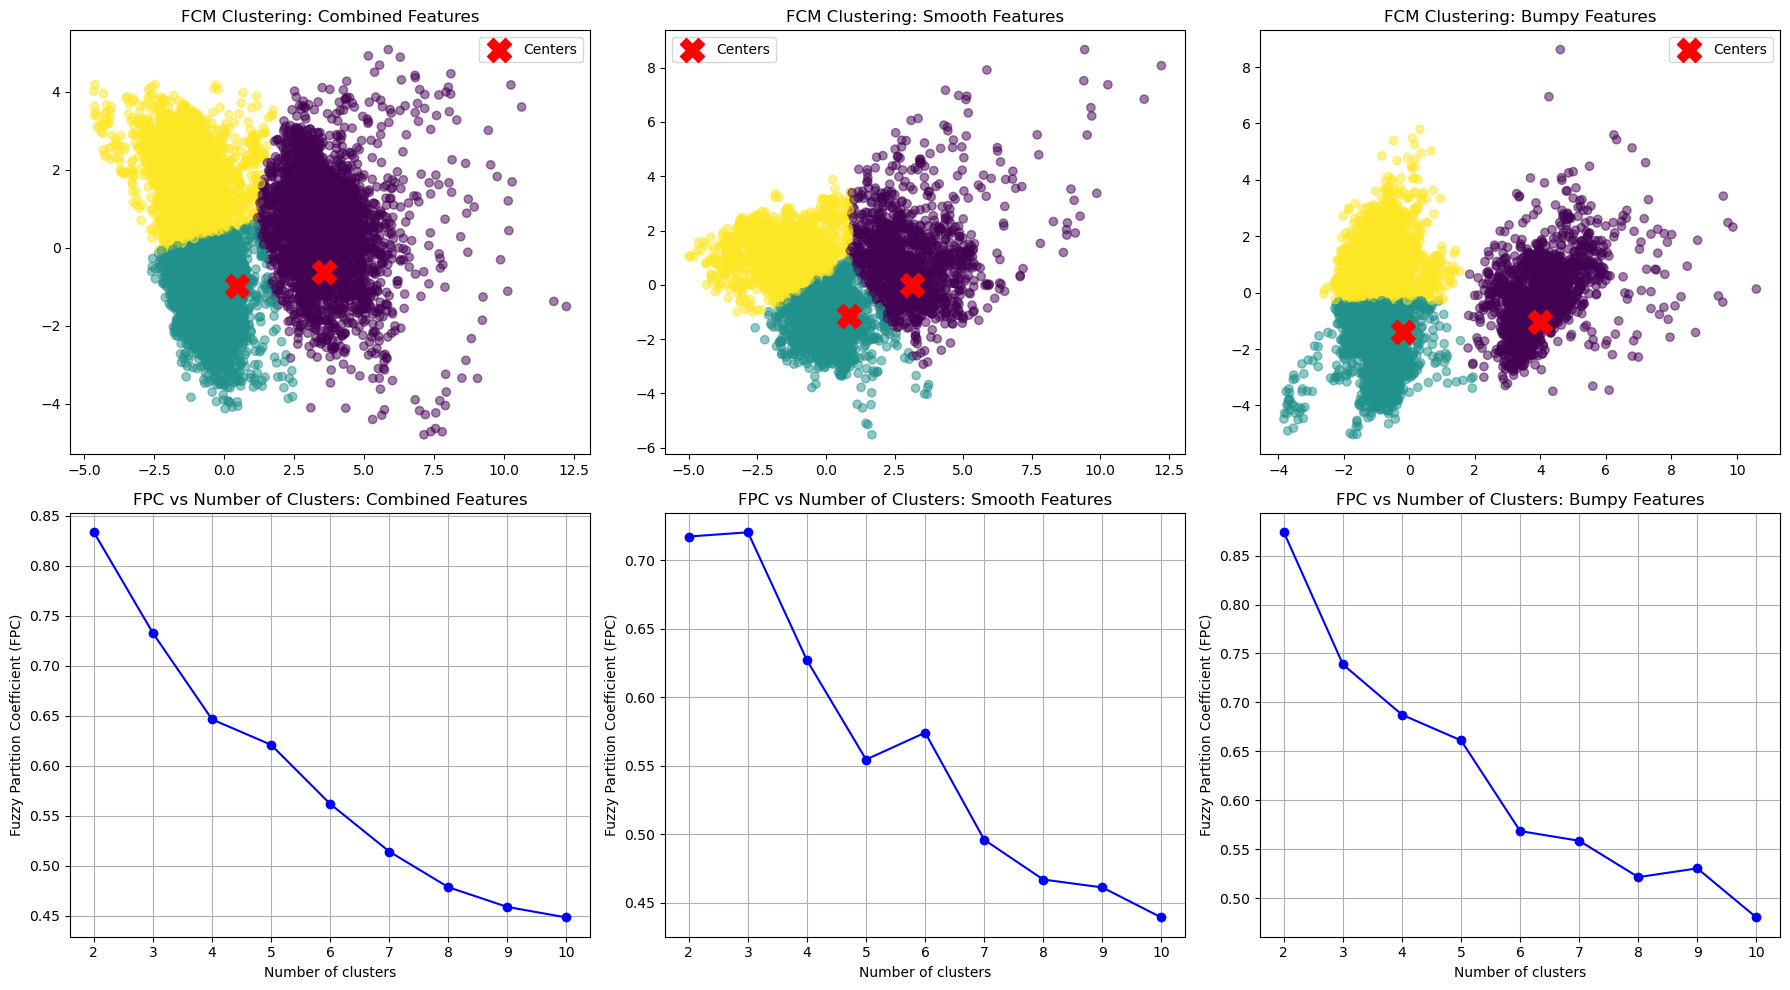

In [44]:
#// BEGIN_TODO Clustering biking data with FCM and determining optimum number of clusters

# Function to perform PCA with 2 components
def apply_pca(data):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data) 
    return reduced_data

# Function to apply FCM
def apply_fcm(data, n_clusters):
    m = 2  
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(data.T, c=n_clusters, m=m, error=0.005, maxiter=1000)
    return cntr, u  # Return only the cluster centers and membership matrix

# Function to visualize FCM clusters
def plot_fcm_clusters(data, cntr, u, ax, title):
    ax.scatter(data[:, 0], data[:, 1], c=u.argmax(axis=0), cmap='viridis', alpha=0.5)
    ax.scatter(cntr[0], cntr[1], s=300, c='red', marker='X', label='Centers')  # Cluster centers
    ax.set_title(f'FCM Clustering: {title}')
    ax.legend()

# Function to visualize FPC 
def visualize_fpc(data, ax, title):
    fpc_values = []
    K_range = range(2, 11) 
    for k in K_range:
        _, u = apply_fcm(data, k)  # Apply FCM and get the membership matrix
        fpc = np.sum(u ** 2) / data.shape[0]  # Calculate FPC
        fpc_values.append(fpc)

    # Plot FPC values
    ax.plot(K_range, fpc_values, 'bo-')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Fuzzy Partition Coefficient (FPC)')
    ax.set_title(f'FPC vs Number of Clusters: {title}')
    ax.set_xticks(K_range)
    ax.grid()

# Apply PCA on each matrix
combined_features_pca = apply_pca(combined_features)
smooth_features_pca = apply_pca(smooth_features)
bumpy_features_pca = apply_pca(bumpy_features)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# FCM for combined features
cntr_combined, u_combined = apply_fcm(combined_features_pca, 3)
plot_fcm_clusters(combined_features_pca, cntr_combined, u_combined, axes[0, 0], 'Combined Features')

# FCM for smooth features
cntr_smooth, u_smooth = apply_fcm(smooth_features_pca, 3)
plot_fcm_clusters(smooth_features_pca, cntr_smooth, u_smooth, axes[0, 1], 'Smooth Features')

# FCM for bumpy features
cntr_bumpy, u_bumpy = apply_fcm(bumpy_features_pca, 3)
plot_fcm_clusters(bumpy_features_pca, cntr_bumpy, u_bumpy, axes[0, 2], 'Bumpy Features')

# Visualize FPC 
visualize_fpc(combined_features_pca, axes[1, 0], 'Combined Features')
visualize_fpc(smooth_features_pca, axes[1, 1], 'Smooth Features')
visualize_fpc(bumpy_features_pca, axes[1, 2], 'Bumpy Features')

plt.tight_layout()
plt.show()

#// END_TODO 

`#// BEGIN_TODO determine optimum number of clusters/qualitatively and compare with k-means`

Determining of the optimum number of clusters for both Fuzzy C-Means (FCM) and K-Means clustering methods using the figures above indicate that 2 to 3 clusters are optimal. The Fuzzy Partition Coefficient (FPC) plots show a clear trend: as the number of clusters increases, the FPC values decrease, suggesting reduced clarity in membership assignments. For combined features, FPC values start high at 2 clusters (around 0.80) and decline sharply until reaching 5 clusters, where the decrease flattens. Similarly, for smooth and bumpy features, FPC values decrease steadily, with significant drops between 3 and 6 clusters. 

The K-Means elbow method also suggests a similar elbow point at 2-3 clusters, indicating diminishing returns in clustering quality beyond this range. The methods used to measure the optimum number of clusters for both algorithms are different, and thus hard to exactly compare to each other directly. But, both methods recommend using 2 or 3 clusters, with FCM offering additional insights for complex data distributions.

`#// END_TODO`


### End of exercise 2.5
---
---

## Part 3: Gaussian Mixture Modeling
The K-Means algorithm is a fast and simple method that works well for many applications. However, due to its simplicity, it isn't suitable for all situations. Fuzzy C-Means (FCM) improves on K-Means by allowing for soft clustering, where data points can belong to multiple clusters with varying degrees of membership. While this flexibility is advantageous, FCM has its own set of limitations. It can be computationally intensive, especially for large datasets, and is sensitive to the initial selection of cluster centers. Additionally, FCM may struggle with outliers, varying cluster sizes, and high-dimensional data, which can lead to suboptimal clustering results.

In this part we present another methodology for clustering data, namely through Gaussian mixture modeling. In this approach we do not rely on a deterministic algorithm for determining the cluster means and assignments, but instead we model the data set by fitting a probability density function.

We will assume that the data set has been generated from a Gaussian mixture model, which is formally specified as
$$ p({\bf{x}}^{(n)}) = \sum_{k=1}^K \rho_k \mathcal{N}({\bf{x}}^{(n)} \mid {\bf{\mu}}_k, \Sigma_k),$$
where a data sample ${\bf{x}}^{(n)}$ is originating from a Gaussian mixture model with $K$ individual Gaussian distributions with means ${\bf{\mu}}_k$ and covariance matrices ${\bf{\Sigma}}_k$. The mean denotes the center or mode of the Gaussian distribution and the covariance matrix specifies the spread and tilt of the Gaussian distribution. In this model the mixing coefficients $\rho_k$ specify how much each of the Gaussian distributions contributes in the model. Because the Gaussian mixture model is a probability density function, integrating over ${\bf{x}}$ should always equal 1. Because the individual Gaussians already satisfy this requirement, the mixing coefficients are constrained by
$$ \sum_{k=1}^K \rho_k = 1.$$
To give some intuition on this model, we give a 1-dimensional example below. Here we model a data set by a mixture of 2 Gaussians. The individual *weighted* Gaussian distributions are colored in blue and the corresponding mixture model distribution is colored in red.

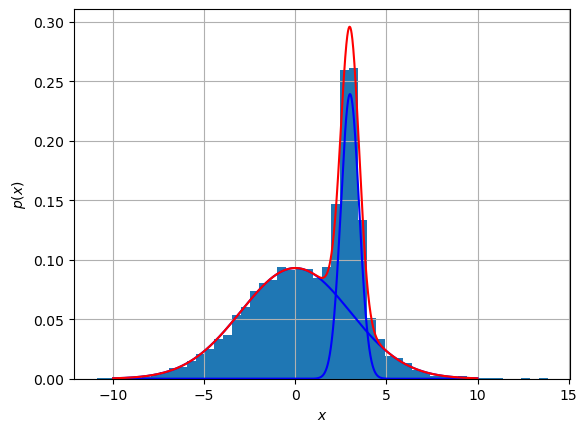

In [45]:
ex4_plot_GMM_1D()

During this part of the assignment you will implement the so-called Expectation-Maximization (EM) algorithm for learning the Gaussian mixture model. This algorithm consists of two steps, the expectation step (E-step) and the maximization step (M-step). The exact details of the algorithm are beyond the scope of this assignment, but here we will present the update equations for these steps.

The EM algorithm works as follows:

1. Initialize the means ${\bf{\mu}}_k$, covariances $\Sigma_k$ and mixing coefficients $\rho_k$. Often the means are initialized using the K-means algorithm. The covariance matrices can be set to identity matrices and the mixing coefficients can be initialized to the fraction of points assigned to the cluster with K-means divided by the total number of samples.
2. *Expectation step*: evaluate the responsibilities $\gamma_{nk}$ using the current parameter values as 
$$ \gamma_{nk} = \frac{\rho_k \mathcal{N}({\bf{x}}_n \mid {\bf{\mu}}_k, \Sigma_k)}{\sum_{j=1}^K \rho_j \mathcal{N}({\bf{x}}_n \mid {\bf{\mu}}_j, \Sigma_j)}$$
3. *Maximization step*: re-estimate the parameters using the current responsibilities
$$ {\bf{\mu}}_k^\text{new} = \frac{1}{N_k} \sum_{n=1}^N \gamma_{nk}{\bf{x}}_n $$
$$ \Sigma_k^\text{new} = \frac{1}{N_k} \sum_{n=1}^N \gamma_{nk} ({\bf{x}}_n - {\bf{\mu}}_k^\text{new})({\bf{x}}_n - {\bf{\mu}}_k^\text{new})^\top $$
$$ \rho_k = \frac{N_k}{N} $$
where $N$ denotes the number of samples and where
$$ N_k = \sum_{n=1}^N \gamma_{nk}$$
4. Evaluate the log-likelihood
$$ \ln p({\bf{X}} \mid {\bf{\mu}}, \Sigma, {\bf{\rho}}) = \sum_{n=1}^N \ln \left\{ \sum_{k=1}^K \rho_k \mathcal{N}({\bf{x}}^{(n)} \mid {\bf{\mu}}_k, \Sigma_k)\right\}$$

It is important to understand what is going on in this algorithm. The responsibilities $\gamma_{nk}$ are similar to the indicator functions from the K-means algorithm. However, where the K-means algorithm performs a hard clustering (each point can be assigned to only 1 cluster), the Gaussian mixture model allows for a soft clustering (each point can be modeled by both Gaussian distributions, but just to a different extent). The indicator function of the K-means algorithm was one-hot coded, meaning that a point was assigned to 1 cluster only. The responsibilities $\gamma_{nk}$ specify how likely a data sample ${\bf{x}}_n$ is to be generated from a cluster. With a Gaussian mixture model a point can therefore be assigned to different extents to multiple clusters. The expectation step calculates these responsibilities and the division in this expression makes sure that all rows sum op to 1.

In the maximization step the parameters are updated. Here the contribution of each data sample towards the parameters depends on the corresponding responsibilities. This means that a point that is very likely to have originated from a certain cluster will have a high influence on the statistics of that cluster. The variable $N_k$ specifies how many points are located to a certain Gaussian distribution. Because this parameter is the summation over the individual responsibilities, $N_k$ is not forced to be an integer.

The log-likelihood is a cost function which takes the variances and uncertainties in our model into account. It describes the probability of that data set being generated from a Gaussian mixture model. To prevent numerical instability we commonly use the log-likelihood instead of the normal likelihood.


---
---
### Exercise 3.1: Initialize clusters
Consider the function from the previous part `X = ex46_generate_data()` which generates a matrix ${\bf{X}}$ of shape (N x D), representing the vertical concatenation of $N$ transposed data vectors of dimension $D$. Create a function `means, covs, rho = initialize_GMM(X, K)` that accepts the data set ${\bf{X}}$ as input and returns the following in this order:
- `means`: a matrix of size (K x D) that contains the initial cluster means, as a vertical concatenation of the transposed mean vectors. These means should be initialized using the previously written K-means algorithm.
- `covs`: a matrix of size (K x D x D) that contains the covariance matrices of the initial clusters. Each matrix `covs[k,:,:]` represents the covariance matrix of the $k^\text{th}$ cluster. Initialize these covariance matrices as identity matrices.
- `rho`: a vector of length K that contains the mixing coefficients as specified above. Initialize this vector based on the indicator function returned by the K-means algorithm.

In [46]:
#// BEGIN_TODO Complete the initialize_GMM(X, K) function

def initialize_GMM(X, K):
    means, rho, _ = Kmeans(X, K)
    covs = np.array([np.identity(X.shape[1]) for _ in range(K)])

    N_k = np.sum(rho, axis=0)
    rho_gmm = N_k / X.shape[0]

    return means, covs, rho_gmm
    
#// END_TODO

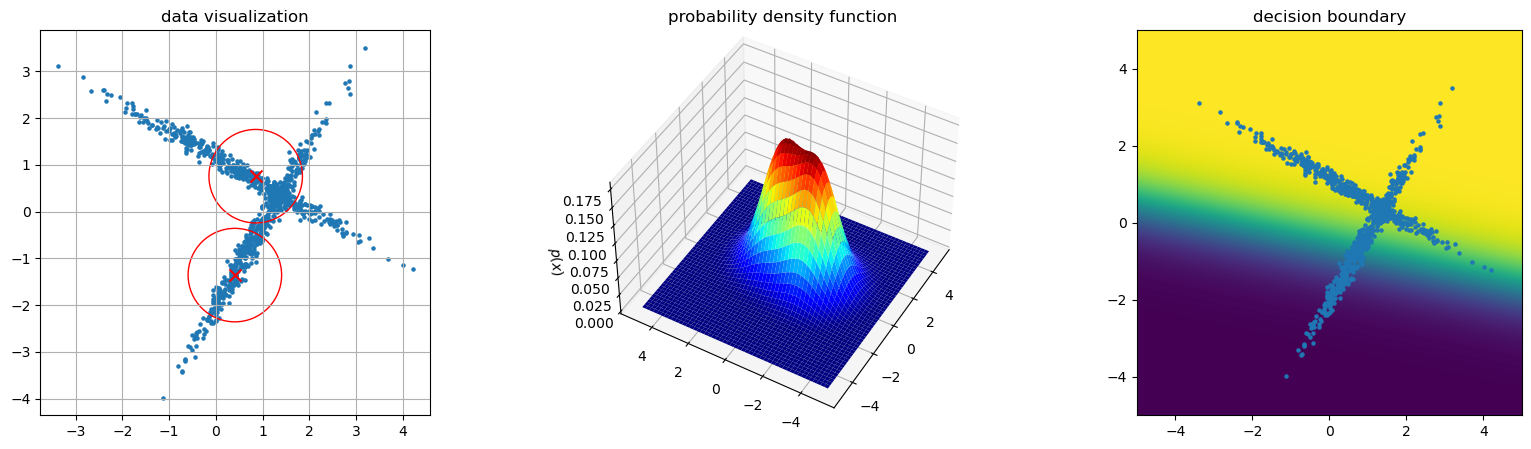

In [47]:
# fetch data
X = ex36_generate_data()

# initialize GMM
means, covs, rho = initialize_GMM(X, 2)

# plot GMM
ex4_plot_GMM(X, means, covs, rho)

### End of exercise 3.1
---
---

---
---
### Exercise 3.2: Expectation step
Create a function `gamma = expectation_step(X, means, covs, rho)` that accepts the data set, means, covariances and mixing coefficients with dimensions specified above. This function should perform the expectation step and should return the calculated responsibilities as defined above as a matrix of size (N x K) where each row corresponds to the assignment fraction of a sample amongst the different clusters. Make sure this matrix is properly normalized such that the elements in each row add up to 1. Use the `multivariate_normal` function that has been imported from `scipy.stats` at the beginning of this notebook.

In [48]:
#// BEGIN_TODO  Complete the expectation_step(X, means, covs, rho) function

def expectation_step(X, means, covs, rho):
    N = X.shape[0]
    K = means.shape[0]
    responsibilities = np.zeros((N, K))

    for n in range(N):
        for k in range(K):
            responsibilities[n,k] = rho[k] * multivariate_normal.pdf(X[n], mean=means[k], cov=covs[k])
        
    responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

    return responsibilities

#// END_TODO

In [49]:
gamma = expectation_step(X, means, covs, rho)

### End of exercise 3.2
---
---

---
---
### Exercise 3.3: Maximization step
Create a function `means, covs, rho = maximization_step(X, gamma)` that accepts the data set and responsibilities with dimensions specified above. This function should perform the maximization step and should return the new means, covariances and mixing coefficients with dimensions as specified above.

In [50]:
#// BEGIN_TODO Complete the maximization_step(X, gamma) function

def maximization_step(X, gamma):
    N_k = np.sum(gamma, axis=0)
    N = X.shape[0]
    K = means.shape[0]
    rho_new = N_k / N
    means_new = np.array([np.sum(gamma[:, k][:, np.newaxis] * X, axis=0) / N_k[k] for k in range(K)])
    covs_new = np.zeros((K, X.shape[1], X.shape[1]))
    for k in range(K):
        diff = X - means_new[k]
        covs_new[k] = np.dot(diff.T, (gamma[:, k][:, np.newaxis] * diff)) / N_k[k] 
    
    return means_new, covs_new, rho_new

#// END_TODO 

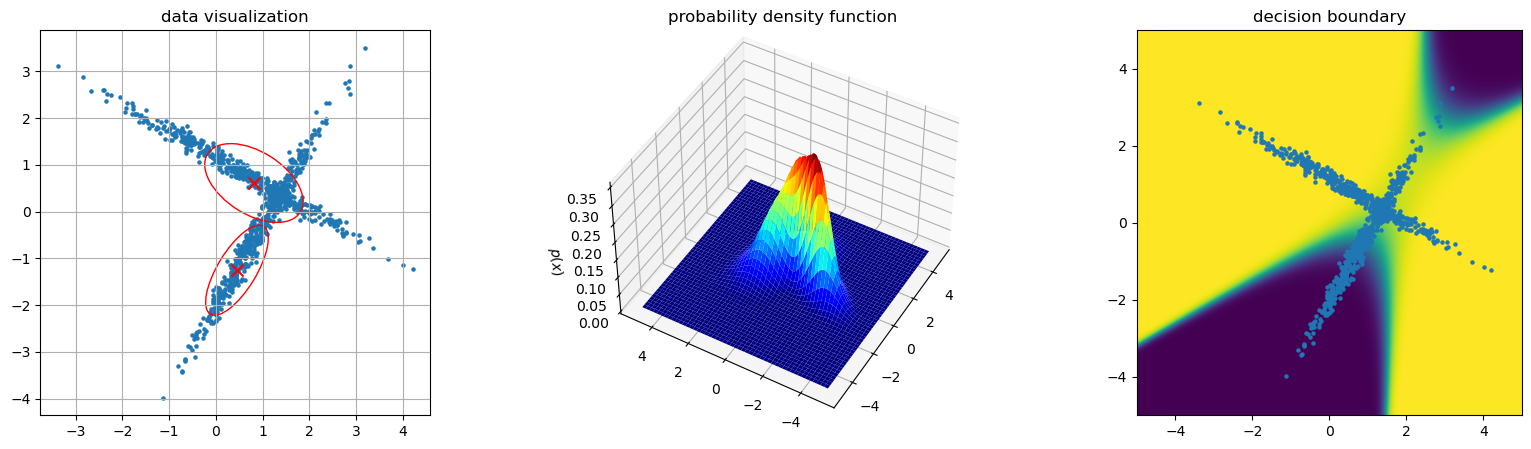

In [51]:
# maximization step
means, covs, rho = maximization_step(X, gamma)

# plot GMM
ex4_plot_GMM(X, means, covs, rho)

### End of exercise 3.3
---
---

---
---
### Exercise 3.4: Log-likelihood calculation
Create a function `J = loglikelihood(X, means, covs, rho)` that accepts the data set, means, covariance matrices and mixing coefficients with dimensions specified above. This function should calculate and return the log-likelihood of the data under the specified Gaussian mixture model. Use the definition as specified in the beginning of Part 3.

In [52]:
#// BEGIN_TODO Complete the loglikelihood(X, means, covs, rho) function

def loglikelihood(X, means, covs, rho):
    N = X.shape[0]
    K = means.shape[0]
    log_likelihoods = 0

    for n in range(N):
        total_likelihood = 0
        for k in range(K):
            total_likelihood += rho[k] * multivariate_normal.pdf(X[n], mean=means[k], cov=covs[k])
        
        log_likelihoods += np.log(total_likelihood)

    return log_likelihoods

#// END_TODO 

### End of exercise 3.4
---
---

---
---
### Exercise 3.5: Gaussian mixture modeling
Now that all the subfunctions have been defined it is time to tie them together and to form a function which does the Gaussian mixture modelling. Create a function `means, covs, rho, gamma, J = GMM_modeling(X, K, nr_iterations)` that does the following:

1. Initialize the parameters of the Gaussian mixture model.
2. Performs `nr_iterations` iterations of the following:
    1. Perform the expectation step.
    2. Perform the maximization step.
    3. Calculate the log-likelihood.
3. returns the parameters and a vector of saved values of the log-likelihood.

The function should return all the parameters of the trained Gaussian mixture model, containing the final means, covariance matrices, mixing coefficients, responsibilities and a vector containing all calculated values of the log-likelihood.

In [53]:
#// BEGIN_TODO Complete the GMM_modeling(X, K, nr_iterations) function

def GMM_modeling(X, K, nr_iterations):
    means, covs, rho = initialize_GMM(X, K)
    saved_log_likelihoods = []

    for iterations in range(nr_iterations):
        gamma = expectation_step(X, means, covs, rho)
        means_new, covs_new, rho_new = maximization_step(X, gamma)
        log_likelihood = loglikelihood(X, means_new, covs_new, rho_new)
        saved_log_likelihoods.append(log_likelihood)

        means = means_new
        covs = covs_new
        rho = rho_new

    saved_log_likelihoods = np.array(saved_log_likelihoods)

    return means_new, covs_new, rho_new, gamma, saved_log_likelihoods

#// END_TODO 

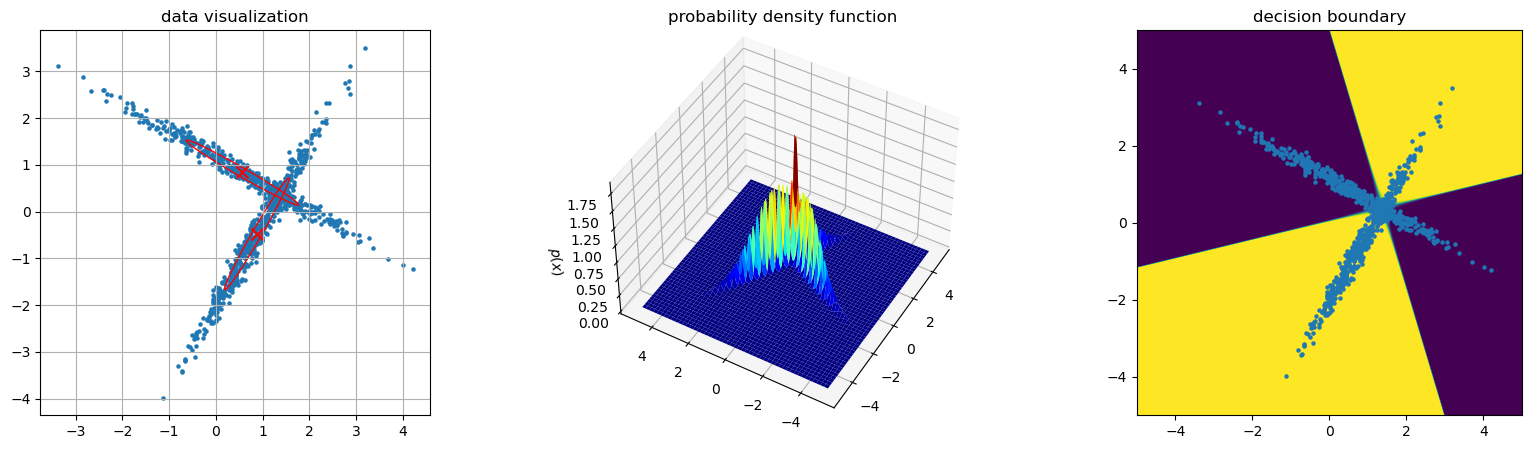

In [54]:
# train GMM
means, covs, rho, gamma, J = GMM_modeling(X, 2, 10)

# plot GMM
ex4_plot_GMM(X, means, covs, rho)

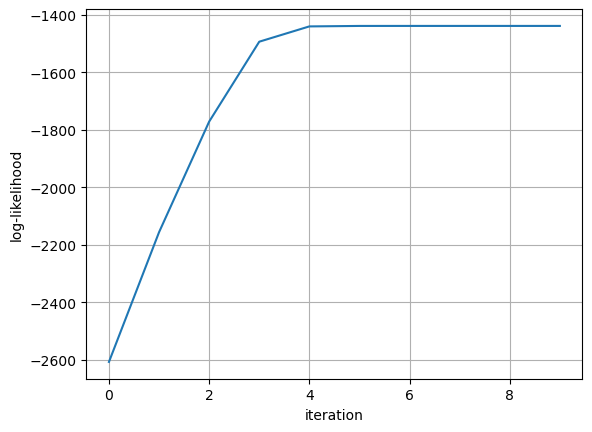

In [55]:
plt.figure()
plt.plot(J)
plt.grid(), plt.xlabel("iteration"), plt.ylabel("log-likelihood");

### End of exercise 3.5
---
---

### Exercise 3.6: Gaussian mixture modeling with biking data
Now that you have an end to end understanding of GMM pipeline, implement your hardcoded methodology on your biking data. Do not forget to perform PCA. For this exercise, use your `combined_features` matrix.

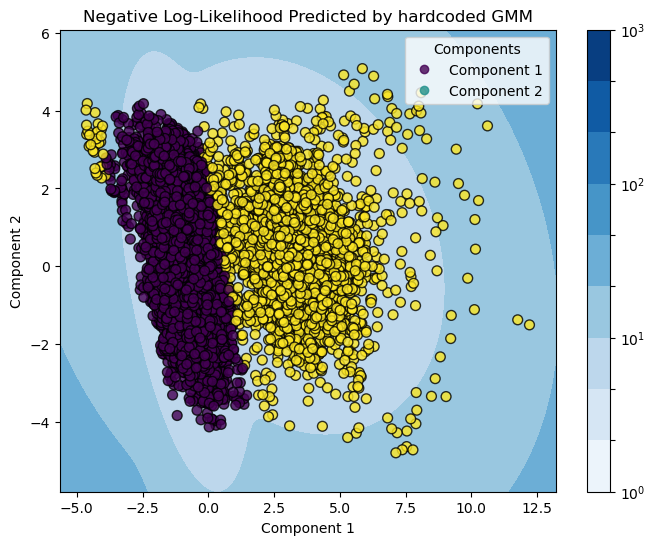

In [56]:
#// BEGIN_TODO Complete the initialize_GMM(X, K) function

# Perform PCA on combined_features 
pca_object = PCA(n_components=2)
combined_pca = pca_object.fit_transform(combined_features)

# Fit GMM using your hardcoded methodology
K = 2 
nr_iterations = 10
means_new, covs_new, rho_new, gamma, saved_log_likelihoods = GMM_modeling(combined_pca, K, nr_iterations)

# Plot GMM contours for PCA data
def plot_gmm_contours_custom(X, means, covs, rho, gamma, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Define the grid
    x = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 300)
    y = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 300)
    X_grid, Y_grid = np.meshgrid(x, y)
    XY = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T
    
    # Calculate the log-likelihood for each point in the grid
    log_likelihoods = np.zeros(XY.shape[0])
    for k in range(len(means)):
        # Calculate the Gaussian probability density for each point in XY
        log_likelihoods += rho[k] * multivariate_normal.pdf(XY, mean=means[k], cov=covs[k])

    # Calculate negative log-likelihoods
    Z = -np.log(log_likelihoods).reshape(X_grid.shape)  # Reshape to match the grid

    # Plot the contour with a logarithmic scale for better visibility
    CS = ax.contourf(X_grid, Y_grid, Z, levels=np.logspace(0, 3, 10), norm=LogNorm(vmin=1.0, vmax=1000.0), cmap='Blues')
    plt.colorbar(CS, ax=ax)
    
    # Component assignments
    labels = np.argmax(gamma, axis=1)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, edgecolor='k', alpha=0.8)

    ax.set_title('Negative Log-Likelihood Predicted by hardcoded GMM')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.axis('tight')

    # Add a legend to the plot
    handles, labels_legend = scatter.legend_elements(num=len(np.unique(labels)))
    ax.legend(handles, [f'Component {i+1}' for i in np.unique(labels)], title="Components")
    
    plt.show()
    
# Call the plot function
plot_gmm_contours_custom(combined_pca, means_new, covs_new, rho_new, gamma)
#// END_TODO 

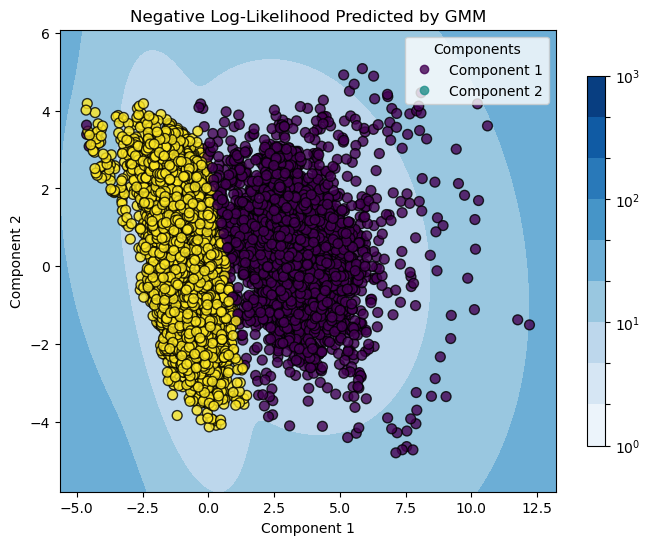

In [57]:
# testing your implementation against sklearn implementation

def plot_gmm_contours(gmm, X, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Define the grid
    x = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 300)
    y = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 300)
    X_grid, Y_grid = np.meshgrid(x, y)
    XY = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T
    
    # Compute the negative log-likelihood of the GMM over the grid
    Z = -gmm.score_samples(XY)
    Z = Z.reshape(X_grid.shape)

    # Plot the contour
    CS = ax.contourf(X_grid, Y_grid, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10), cmap='Blues')
    CB = plt.colorbar(CS, ax=ax, shrink=0.8, extend='both')
    
    # Predict the component assignments for each data point
    labels = gmm.predict(X)
    
    # Plot data points with colors based on component assignment
    scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, edgecolor='k', alpha=0.8)
    
    ax.set_title('Negative Log-Likelihood Predicted by GMM')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.axis('tight')

    # Add a legend to the plot
    handles, labels_legend = scatter.legend_elements(num=len(np.unique(labels)))
    ax.legend(handles, [f'Component {i+1}' for i in np.unique(labels)], title="Components")
    
    plt.show()

# Perform PCA
pca_object = PCA(n_components=2)  # Replace ICA with PCA
data_pca = pca_object.fit_transform(combined_features)  # Apply PCA to combined_features

# Fit GMM on PCA-transformed data
gmm_pca = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_pca.fit(data_pca)

# Plot GMM contours for PCA data
plot_gmm_contours(gmm_pca, data_pca)


### End of exercise 3.6
---
---


### Exercise 3.7: Number of GMM components
Proceeding with the sklearn implementation, employ different elbow based quantitative techniques to decide optimum number of components. Employ your `combined_features` matrix and sklearn implementation.

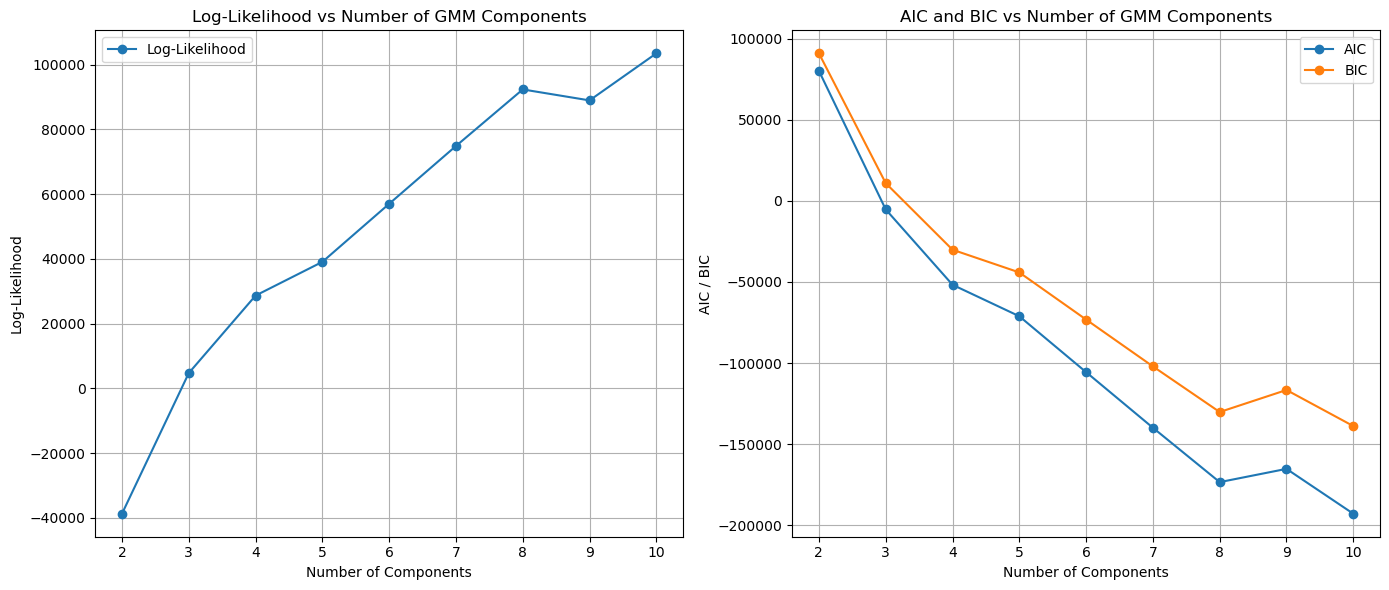

In [58]:
#// BEGIN_TODO determine number of GMM components

# Lists to store the results
log_likelihoods = []
aic_values = []
bic_values = []

# Fit GMM models for each number of components
for n_components in range(2, 11):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    
    # Fit the GMM model to the data
    gmm.fit(combined_features)
    
    # Compute total log-likelihood (average log-likelihood times number of samples)
    total_log_likelihood = gmm.score(combined_features) * len(combined_features)
    log_likelihoods.append(total_log_likelihood)
    
    # Compute AIC and BIC for the current model
    aic_values.append(gmm.aic(combined_features))
    bic_values.append(gmm.bic(combined_features))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Log-Likelihood Elbow Method
axes[0].plot(range(2, 11), log_likelihoods, marker='o', label='Log-Likelihood')
axes[0].set_title('Log-Likelihood vs Number of GMM Components')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Log-Likelihood')
axes[0].grid(True)
axes[0].legend()

# Subplot 2: AIC and BIC values
axes[1].plot(range(2, 11), aic_values, marker='o', label='AIC')
axes[1].plot(range(2, 11), bic_values, marker='o', label='BIC')
axes[1].set_title('AIC and BIC vs Number of GMM Components')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('AIC / BIC')
axes[1].grid(True)
axes[1].legend()

# Show both plots
plt.tight_layout()
plt.show()

#// END_TODO 


`#// BEGIN_TODO determine number of GMM components`

To determine the optimal number of components, we have computed the total log-likelihood per component and plotted it, aswell as plotting the AIC/BIC scores per components. As we can see, while the log-likelihood keeps improving as we add more components, we start to see diminishing returns after 8 components. Looking at the AIC and BIC plot, we observe a similar pattern. Both the AIC and BIC steadily decrease up until 8 components and this tells us that the model's goodness of fit is improving steadily. It is only after 8 componetns that we see diminishing returns in AIC and BIC, indicating that adding more components beyond this point introduces additional complexity without significantly improving the model. Therefore, considering both the log-likelihood plot and the AIC/BIC plot, it is clear that the optimal number of components is 8.


`#// END_TODO `


### End of exercise 3.7
---
---

### Exercise 3.8: Building the bumpy lane detector
You made it this far. We are almost there. Now, train two gaussian mixture models, one using your smooth data `smooth_features` and one using your `bumpy_features`. For this assignment you are provided with a testing data taken from biking in Tilburg for 17 minutes on biking lane with diverse features. You are requested to employ your models to determine which segments of the road are bumpy and which segments are smooth. You must employ your preprocessing skills and provide your judgement on road segments for each 30 second segment. 
for example : bumpy, smooth, smooth, bumpy, smooth, etc... until end of the road!
Good luck

In [59]:
#// BEGIN_TODO train two GMM models

n_components = 8 

pca_smooth = PCA(n_components=2)
smooth_features_pca = pca_smooth.fit_transform(smooth_features)

pca_bumpy = PCA(n_components=2)
bumpy_features_pca = pca_bumpy.fit_transform(bumpy_features)

gmm_smooth = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm_bumpy = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)

gmm_smooth.fit(smooth_features_pca)
gmm_bumpy.fit(bumpy_features_pca)

#// END_TODO 


GaussianMixture(n_components=8, random_state=42)

In [60]:
#// BEGIN_TODO Preproces Tilburg data

recording_folder_path = "Tilburg/"

def load_recording_tilburg(recording_folder_path):
    # CSV files we are interested in
    required_files = ['Accelerometer.csv', 'Gravity.csv', 'Gyroscope.csv']
    
    # Columns to add suffixes
    columns_to_suffix = ['z', 'y', 'x']
    
    data = pd.DataFrame()
    
    for filename in required_files:
        file_path = os.path.join(recording_folder_path, filename)
        
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Drop the 'time' column 
        if 'time' in df.columns:
            df.drop(columns=['time'], inplace=True)
        
        # Add suffix to sensor columns to avoid collisions when merging
        if 'Accelerometer' in filename:
            df.columns = [col + '_Accelerometer' if col in columns_to_suffix else col for col in df.columns]
        elif 'Gyroscope' in filename:
            df.columns = [col + '_Gyroscope' if col in columns_to_suffix else col for col in df.columns]
        elif 'Gravity' in filename:
            df.columns = [col + '_Gravity' if col in columns_to_suffix else col for col in df.columns]
        
        # First file sets the base data
        if data.empty:
            data = df
        else:
            # Perform the merge asof
            data = pd.merge_asof(data, df, on='seconds_elapsed', direction='nearest')

    # Remove NaN values
    data.dropna(inplace=True)

    # Reset the index to keep it clean
    data.reset_index(drop=True, inplace=True)

    return data

def trim_df_tilburg(data):
    last_time = data["seconds_elapsed"].iloc[-1]
    data_trimmed = data[(data["seconds_elapsed"] > 5) & (data["seconds_elapsed"] < last_time - 5)]
    return data_trimmed

def normalize_df_tilburg(data):
    for col in data.columns:
        if col == "seconds_elapsed":
            continue
        data[col] = (data[col] - data[col].mean()) / data[col].std()
    return data

def segment_data_tilburg(mat, fun, interval_length=30, overlap_length=15):

    L = int(interval_length / 0.01)  # Number of rows for the 30-second interval
    K = int(overlap_length / 0.01)    # Number of rows for the 15-second overlap
    
    stride = L - K  # Calculate stride for overlapping segments
    
    # Store the processed segments
    segment_list = []
    
    for i in range(0, mat.shape[0] - L + 1, stride):
        segment = mat[i:i + L]
        
        # Process the segment based on the specified function
        if fun == "mean":
            processed_segment = np.mean(segment, axis=0)
        elif fun == "std":
            processed_segment = np.std(segment, axis=0)
        elif fun == "minimum":
            processed_segment = np.min(segment, axis=0)
        elif fun == "maximum":
            processed_segment = np.max(segment, axis=0)
        
        segment_list.append(processed_segment)
    
    return np.array(segment_list)

# Load the data
df = load_recording_tilburg(recording_folder_path)

df = trim_df_tilburg(df)

df = normalize_df_tilburg(df)

mat_merged = df.drop(columns=["seconds_elapsed"]).to_numpy()

# Calculate features using the new segment function
Y_mean = segment_data_tilburg(mat_merged, "mean", interval_length=30, overlap_length=15)
Y_std = segment_data_tilburg(mat_merged, "std", interval_length=30, overlap_length=15)
Y_minimum = segment_data_tilburg(mat_merged, "minimum", interval_length=30, overlap_length=15)
Y_maximum = segment_data_tilburg(mat_merged, "maximum", interval_length=30, overlap_length=15)

features = [Y_mean, Y_std, Y_minimum, Y_maximum]

for idx, feature in enumerate(features):
    if idx == 0:
        tilburg_features = feature
    else:
        tilburg_features = np.concatenate((tilburg_features, feature), axis=1)

print(tilburg_features.shape)

#// END_TODO 


(66, 36)


In [61]:
#// BEGIN_TODO Classify Tilburg biking lane

pca = PCA(n_components=2)
combined_features_pca = pca.fit_transform(combined_features)
tilburg_features_pca = pca.transform(tilburg_features)
predictions = []
for row in tilburg_features_pca:
    # Reshape the row to fit the GMM input (1 sample, D features)
    row_reshaped = row.reshape(1, -1)
    
    # Compute log-likelihood for the row under both GMM models
    log_likelihood_bumpy = gmm_bumpy.score(row_reshaped)
    log_likelihood_smooth = gmm_smooth.score(row_reshaped)
    
    # Compare the log-likelihoods to classify as bumpy or smooth
    if log_likelihood_bumpy > log_likelihood_smooth:
        predictions.append("bumpy")
    else:
        predictions.append("smooth")

num_smooth_predicted = predictions.count('smooth')
num_bumpy_predicted = predictions.count('bumpy')
print(f"Number of segments predicted as smooth: {num_smooth_predicted}")
print(f"Number of segments predicted as smooth: {num_bumpy_predicted}")

#// END_TODO 


Number of segments predicted as smooth: 16
Number of segments predicted as smooth: 50


Based on the data you’ve collected and the predictions you've made, summarize your opinion on the overall quality of Tilburg’s biking lanes. In no more than 100 words, provide your general impression of the road conditions, highlighting whether the lanes are predominantly smooth or bumpy. Additionally, offer any recommendations for potential improvements based on the results of your analysis.

In [62]:
#// Tilburg lane quality

answer = """
The predictions indicate that these Tilburg biking lanes are predominantly bumpy, with 50 out of 66 segments classified as such. This suggests a need for significant improvements in road maintenance and surface quality to enhance cyclist safety and 
comfort. To address these issues, I recommend conducting regular inspections and implementing a maintenance schedule focused on repairing and resurfacing bumpy areas. 
"""

print(answer)
#// END_TODO 


The predictions indicate that these Tilburg biking lanes are predominantly bumpy, with 50 out of 66 segments classified as such. This suggests a need for significant improvements in road maintenance and surface quality to enhance cyclist safety and 
comfort. To address these issues, I recommend conducting regular inspections and implementing a maintenance schedule focused on repairing and resurfacing bumpy areas. 



### End of exercise 3.8
---
---

> Make sure to restart this notebook and to rerun all cells before submission to check whether all code runs properly.

# End of Assignment 1b